In [1]:
from pathlib import Path
import sys


here = Path.cwd()
candidates = [here] + list(here.parents)
for p in candidates:
    if (p / "Code").is_dir():
        sys.path.insert(0, str(p))
        break
else:
    raise RuntimeError("Couldn't find a 'Code' folder in this project.")


import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
import pandas as pd


from Code.PINN import create_network_model, u, compute_loss, g_trial_tf, train_step, compute_MSE
from Code.functions import euler, analytical_u

In [2]:
dx1 = 0.1
dt1 = 0.005        # stability limit: dt = dx^2 / 2 = 0.005
x1, t1, U1 = euler(dx1, dt1, T=0.2)

# Case 2: dx = 0.01
dx2 = 0.01
dt2 = 5e-5         # stability limit: dt = dx^2 / 2 = 5e-5
x2, t2, U2 = euler(dx2, dt2, T=0.2)

In [3]:
t1_val, t2_val = 0.01, 0.1


n1_1 = np.argmin(np.abs(t1 - t1_val))
n2_1 = np.argmin(np.abs(t1 - t2_val))

n1_2 = np.argmin(np.abs(t2 - t1_val))
n2_2 = np.argmin(np.abs(t2 - t2_val))


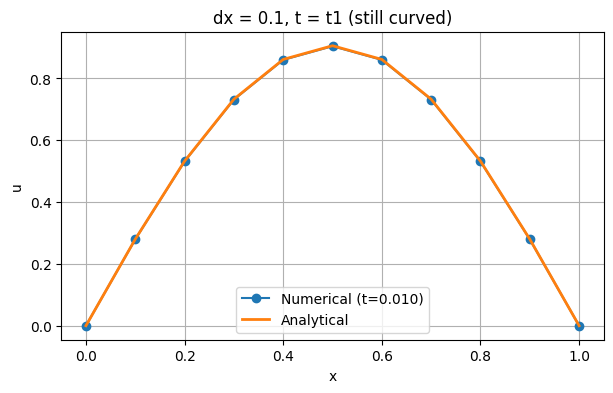

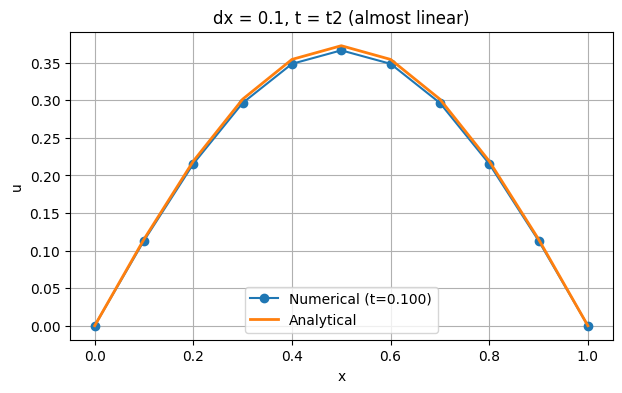

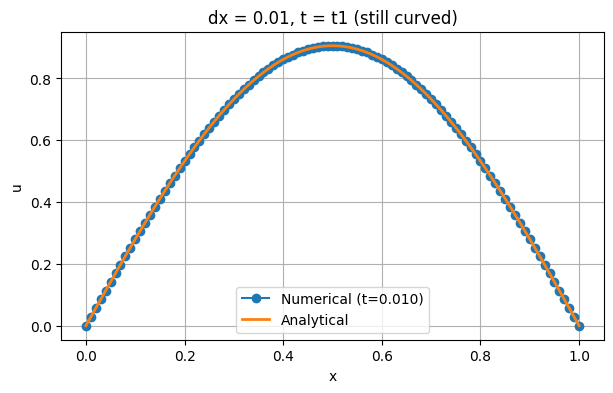

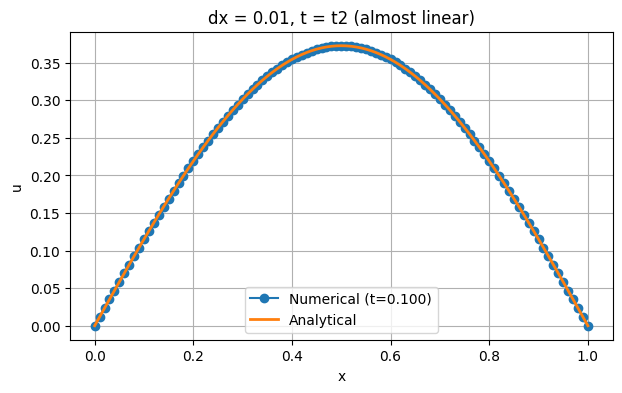

In [4]:
def plot_comparison(x, U, t_grid, n_idx, title):
    t_val = t_grid[n_idx]
    u_num = U[n_idx]
    u_exact = analytical_u(x, t_val)

    plt.figure(figsize=(7,4))
    plt.plot(x, u_num, 'o-', label=f"Numerical (t={t_val:.3f})")
    plt.plot(x, u_exact, '-', label="Analytical", lw=2)
    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("u")
    plt.legend()
    plt.grid(True)
    plt.show()


plot_comparison(x1, U1, t1, n1_1, "dx = 0.1, t = t1 (still curved)")
plot_comparison(x1, U1, t1, n2_1, "dx = 0.1, t = t2 (almost linear)")

plot_comparison(x2, U2, t2, n1_2, "dx = 0.01, t = t1 (still curved)")
plot_comparison(x2, U2, t2, n2_2, "dx = 0.01, t = t2 (almost linear)")

In [5]:
NN_model = create_network_model(layers=[6, 7], activation='sigmoid')

2025-12-07 10:37:13.087840: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-12-07 10:37:13.087862: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-12-07 10:37:13.087870: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2025-12-07 10:37:13.087885: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-12-07 10:37:13.087897: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
N_points = 1000  # Number of collocation points (x, t) in the domain
epochs = 5000  # Number of training epochs

T_final = 0.5 # Example final time
x_samples = np.random.uniform(0.0, 1.0, N_points)
t_samples = np.random.uniform(0.0, T_final, N_points)
X_train = np.stack([x_samples, t_samples], axis=1).astype(np.float32)

In [7]:
#training 
@tf.function #convert to TF graph for performance
def train_step(X_train_batch):
    # GradientTape records operations to compute gradients
    with tf.GradientTape() as tape:
        # Calculate the loss for the current batch of points
        loss = compute_loss(NN_model, X_train_batch)
        
    # Calculate gradients of the loss with respect to all trainable network variables
    trainable_vars = NN_model.trainable_variables
    gradients = tape.gradient(loss, trainable_vars)
    
    # Apply gradients to update weights using the optimizer
    optimizer.apply_gradients(zip(gradients, trainable_vars))
    return loss


for epoch in range(epochs):
    # In a simple PINN, we often use a single large batch covering the domain,
    # or resample the collocation points each epoch.
    current_loss = train_step(X_train)
    
    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {current_loss.numpy():.6e}")


2025-12-07 10:37:13.628115: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


Epoch 50/5000, Loss: 1.015454e+01
Epoch 100/5000, Loss: 8.777571e+00
Epoch 150/5000, Loss: 8.746046e+00
Epoch 200/5000, Loss: 8.694386e+00
Epoch 250/5000, Loss: 8.584612e+00
Epoch 300/5000, Loss: 8.372661e+00
Epoch 350/5000, Loss: 7.961452e+00
Epoch 400/5000, Loss: 7.242023e+00
Epoch 450/5000, Loss: 6.199103e+00
Epoch 500/5000, Loss: 5.214310e+00
Epoch 550/5000, Loss: 4.605744e+00
Epoch 600/5000, Loss: 4.263235e+00
Epoch 650/5000, Loss: 4.050688e+00
Epoch 700/5000, Loss: 3.908828e+00
Epoch 750/5000, Loss: 3.809051e+00
Epoch 800/5000, Loss: 3.735333e+00
Epoch 850/5000, Loss: 3.678237e+00
Epoch 900/5000, Loss: 3.632248e+00
Epoch 950/5000, Loss: 3.594140e+00
Epoch 1000/5000, Loss: 3.561898e+00
Epoch 1050/5000, Loss: 3.534133e+00
Epoch 1100/5000, Loss: 3.509832e+00
Epoch 1150/5000, Loss: 3.488246e+00
Epoch 1200/5000, Loss: 3.468823e+00
Epoch 1250/5000, Loss: 3.451163e+00
Epoch 1300/5000, Loss: 3.435000e+00
Epoch 1350/5000, Loss: 3.420185e+00
Epoch 1400/5000, Loss: 3.406668e+00
Epoch 1450/5

In [8]:
def pinn_solution(model, x, t_value, N_output=1):
    X_eval = np.stack([x, np.full_like(x, t_value)], axis=1).astype(np.float32)
    g_val = g_trial_tf(X_eval, model, N_output)
    return g_val.numpy().flatten()


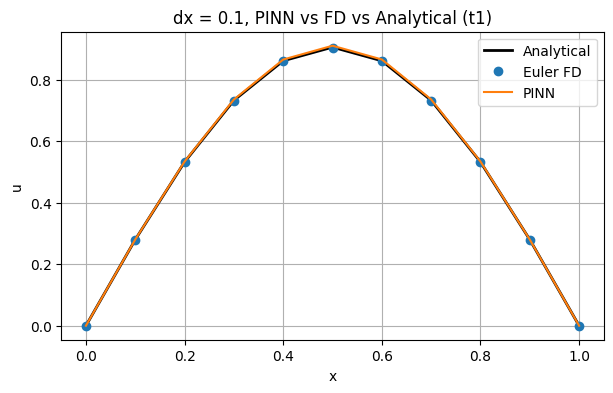

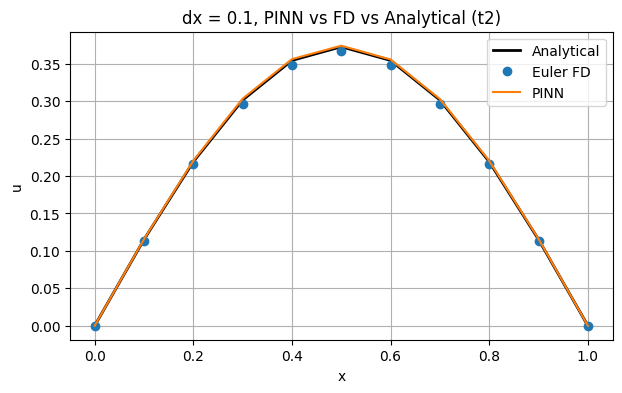

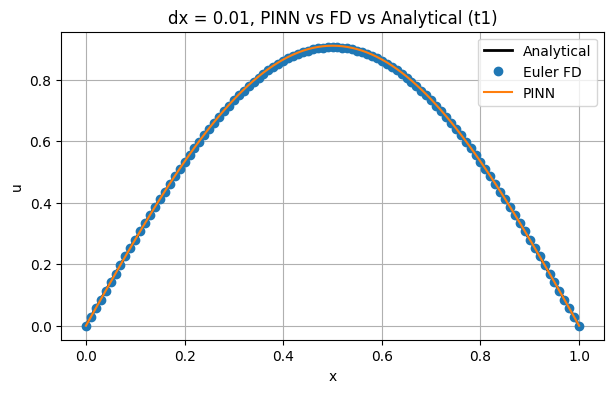

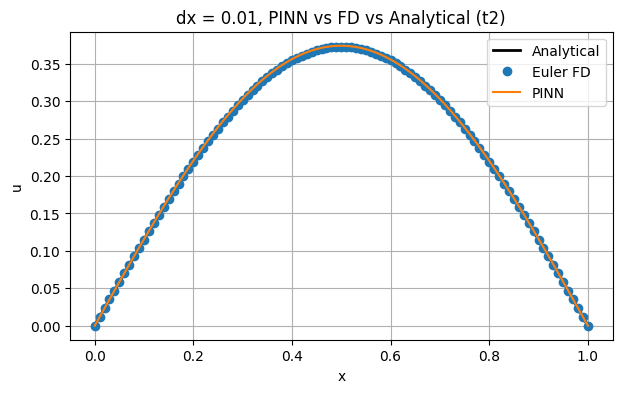

In [9]:
def plot_all(x, t_grid, U, t_target, NN_model, title, N_output=1):
    n_idx = np.argmin(np.abs(t_grid - t_target))
    u_euler = U[n_idx]
    u_exact = analytical_u(x, t_target)
    u_pinn  = pinn_solution(NN_model, x, t_target, N_output)

    plt.figure(figsize=(7,4))
    plt.plot(x, u_exact, 'k-', lw=2, label="Analytical")
    plt.plot(x, u_euler, 'o', label="Euler FD")
    plt.plot(x, u_pinn, '-', label="PINN")
    plt.xlabel("x")
    plt.ylabel("u")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


t1_val, t2_val = 0.01, 0.10

plot_all(x1, t1, U1, t1_val, NN_model, "dx = 0.1, PINN vs FD vs Analytical (t1)", N_output=N_points)
plot_all(x1, t1, U1, t2_val, NN_model, "dx = 0.1, PINN vs FD vs Analytical (t2)", N_output=N_points)

plot_all(x2, t2, U2, t1_val, NN_model, "dx = 0.01, PINN vs FD vs Analytical (t1)", N_output=N_points)
plot_all(x2, t2, U2, t2_val, NN_model, "dx = 0.01, PINN vs FD vs Analytical (t2)", N_output=N_points)

In [ ]:

widths = [5, 10, 20, 50, 100]
results_nodes = []

epochs = 3000 

for w in widths:
    print(f"\n=== Width experiment: {w} neurons, 1 hidden layer, tanh ===")
    model = create_network_model(layers=[w], activation='tanh')
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

    for epoch in range(epochs):
        loss = train_step(X_train)
        if epoch % 500 == 0:
            print(f"  Epoch {epoch}: loss = {loss.numpy():.3e}")

    mse = compute_MSE(model, T_final=T_final)
    results_nodes.append((w, float(loss.numpy()), mse))
    print(f"Final residual loss: {loss.numpy():.3e}, MSE vs exact: {mse:.3e}")

df_nodes = pd.DataFrame(results_nodes, columns=["Width", "Residual loss", "MSE"])
print(df_nodes)



=== Width experiment: 5 neurons, 1 hidden layer, tanh ===


TypeError: Binding inputs to tf.function failed due to `too many positional arguments`. Received args: (<Sequential name=sequential_1, built=True>, <keras.src.optimizers.adam.Adam object at 0x3164e0e90>, array([[0.53562653, 0.08490574],
       [0.72752196, 0.496465  ],
       [0.63036346, 0.08265478],
       ...,
       [0.3583199 , 0.2558457 ],
       [0.2138215 , 0.35030404],
       [0.1380878 , 0.42227337]], dtype=float32)) and kwargs: {} for signature: (X_train_batch).